# <font face = 'Impact' color = '#FFAEBC' > Predicting Spotify Track Popularity: Demonstration on Machine Learning for Regression<font/>
#### <font face = 'Times New Roman' color = '#B5E5CF'> License: GPL v3.0<font/>
#### <font face = 'Times New Roman' color = '#FFFF00'> Members: <font/>
#### <font face = 'Times New Roman' color = '#B5E5CF'> Jemmar V. Padernal BSIS-4B<font/>
#### <font face = 'Times New Roman' color = '#B5E5CF'> Lance Gabriel Masigon BSIS-4B<font/>
#### <font face = 'Times New Roman' color = '#B5E5CF'> Angelo Cawa BSIS-4B<font/>
#### <font face = 'Times New Roman' color = '#B5E5CF'> Althea Jane Roselo Trinidad BSIS-4A<font/>


This notebook provides a backgrounder in doing Machine Learning in Python employing models such as Ridge Regression, LASSO Regression, Elastic Net, and Random Forest Regressor. 

# Business Understanding

## Problem Statement
Spotify seeks to gain a deeper understanding of the factors that drive track popularity on its platform. The Data Analytics department has provided a comprehensive Spotify dataset containing track, artist, album, and performance-related variables. The primary business objective is to develop a predictive model that accurately estimates a track's PopularityScore based on key predictors such as track number, explicit content, artist popularity, artist followers, album total tracks, track duration, and other metadata.

By identifying and quantifying the most influential drivers of track popularity, the organization aims to:

- Improve music recommendation algorithms and playlist curation,
- Optimize artist development and marketing strategies,
- Support data-driven decision-making in content promotion and artist partnerships,
- Enhance user engagement and platform satisfaction.

The success of this initiative will be measured by the model's ability to accurately predict track popularity and provide actionable insights that inform content strategies and user experience improvements.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and explore the dataset
df = pd.read_csv('spotify_data.csv')
print(df.head())
print(df.info())
print(df.describe())

                 track_id                                       track_name  \
0  3EJS5LyekDim1Tf5rBFmZl                    Trippy Mane (ft. Project Pat)   
1  1oQW6G2ZiwMuHqlPpP27DB                                             OMG!   
2  7mdkjzoIYlf1rx9EtBpGmU                                      Hard 2 Find   
3  67rW0Zl7oB3qEpD5YWWE5w  Still Get Like That (ft. Project Pat & Starrah)   
4  15xptTfRBrjsppW0INUZjf                            ride me like a harley   

   track_number  track_popularity  explicit artist_name  artist_popularity  \
0             4                 0      True       Diplo                 77   
1             1                 0      True    Yelawolf                 64   
2             1                 4      True   Riff Raff                 48   
3             8                30      True       Diplo                 77   
4             2                 0      True     Rumelis                 48   

   artist_followers                      artist_genres  \
0   

In [3]:
# Check for spaces (though unlikely in CSV)
print(df.eq(' ').any())

track_id              False
track_name            False
track_number          False
track_popularity      False
explicit              False
artist_name           False
artist_popularity     False
artist_followers      False
artist_genres         False
album_id              False
album_name            False
album_release_date    False
album_total_tracks    False
album_type            False
track_duration_min    False
dtype: bool


# Data Understanding

The dataset provided by the Spotify Data Analytics department contains detailed records for tracks on the platform. The primary purpose of this data is to support an analytical exploration of factors influencing track popularity, represented by the response variable track_popularity.

The dataset includes a mix of track, artist, album, and performance-related variables that may influence popularity. The predictor variables are as follows:

- track_number – The position of the track in the album.
- explicit – Whether the track contains explicit content (boolean).
- artist_popularity – The popularity score of the artist.
- artist_followers – The number of followers the artist has.
- album_total_tracks – The total number of tracks in the album.
- track_duration_min – The duration of the track in minutes.
- Other metadata such as artist_genres, album_release_date, album_type.

The dataset is expected to include both numerical and categorical data types, potentially with varying scales and distributions. Before modeling, the data will need to be explored and preprocessed to ensure quality and reliability. This will involve checking for missing values, outliers, inconsistent data entries, and correlations among variables. Exploratory Data Analysis (EDA) will also be performed to uncover patterns, relationships, and possible drivers of track popularity.

Understanding these characteristics will guide appropriate feature engineering, data transformation, and model selection steps to ensure that the resulting machine learning model accurately reflects the underlying dynamics of track popularity on the platform.

# <span style="color:yellow">Data Preparation</span>


In [4]:
# Drop irrelevant features
df = df.drop(['track_id', 'track_name', 'artist_name', 'artist_genres', 'album_id', 'album_name', 'album_release_date'], axis=1)
print(df.head())

   track_number  track_popularity  explicit  artist_popularity  \
0             4                 0      True                 77   
1             1                 0      True                 64   
2             1                 4      True                 48   
3             8                30      True                 77   
4             2                 0      True                 48   

   artist_followers  album_total_tracks album_type  track_duration_min  
0           2812821                   9      album                1.55  
1           2363438                   1     single                3.07  
2            193302                   1     single                2.55  
3           2813710                   9      album                1.69  
4              8682                   2     single                2.39  


In [5]:
# Split the dataset
train, test = train_test_split(df, test_size=0.30, random_state=42)
print(f'''The number of records for the train set is {len(train)}.
The number of records for the test set is {len(test)}.''')

The number of records for the train set is 6007.
The number of records for the test set is 2575.


In [6]:
# Separate explanatory and outcome variables
x_train = train.drop(['track_popularity'], axis=1)
y_train = train['track_popularity']
x_test = test.drop(['track_popularity'], axis=1)
y_test = test['track_popularity']

In [7]:
# Define continuous and categorical variables
continuous_vars = ['track_number', 'artist_popularity', 'artist_followers', 'album_total_tracks', 'track_duration_min']
categorical_vars = ['explicit', 'album_type']

In [8]:
# Create preprocessor for consistent scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_vars),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
    ]
)

In [9]:
# Fit preprocessor on x_train and transform both train and test
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

In [10]:
# Get feature names for DataFrame conversion
feature_names = continuous_vars + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars))
x_train = pd.DataFrame(x_train_processed, columns=feature_names, index=x_train.index)
x_test = pd.DataFrame(x_test_processed, columns=feature_names, index=x_test.index)

In [11]:
# Save the preprocessor for hypothetical data
pickle.dump(preprocessor, open('preprocessor.pkl', 'wb'))


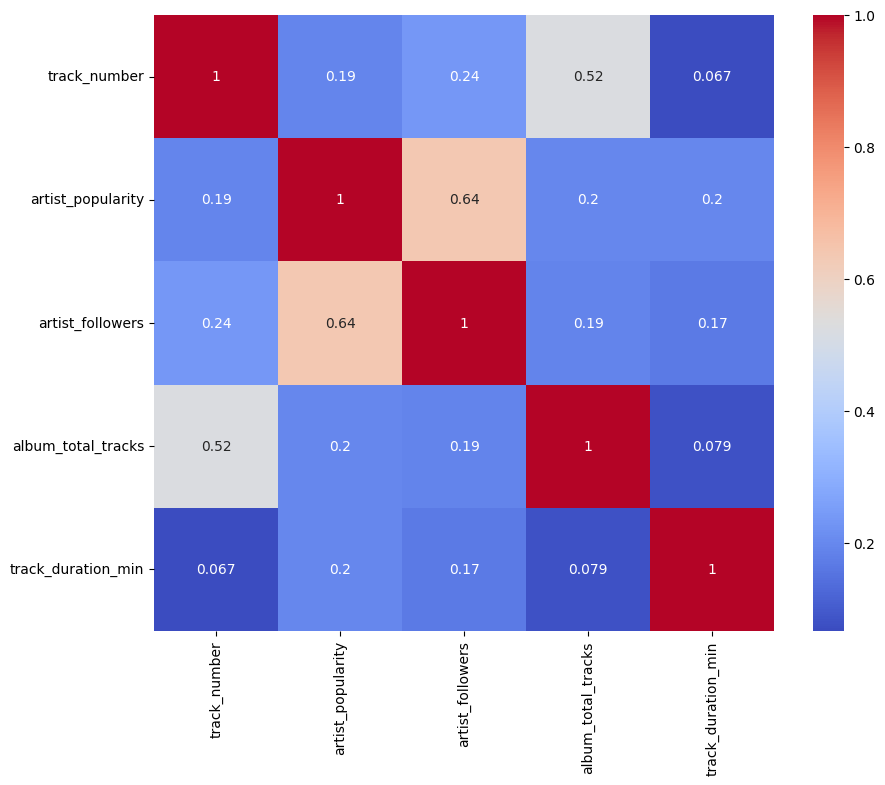

In [12]:
# Correlation heatmap (on scaled continuous vars only, as encoded vars are binary)
plt.figure(figsize=(10, 8))
sns.heatmap(x_train[continuous_vars].corr(), annot=True, cmap='coolwarm')
plt.show()

In [13]:
# Ridge Regression
ridge = Ridge()
param_grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10.0], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error')
grid_search_ridge.fit(x_train, y_train)
print("Ridge Best hyperparameters:", grid_search_ridge.best_params_)
best_ridge = grid_search_ridge.best_estimator_
cv_rmse_ridge = -grid_search_ridge.best_score_
print("Ridge Mean 5-fold CV RMSE:", np.round(cv_rmse_ridge, 2))
y_train_pred_ridge = best_ridge.predict(x_train)
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
print("Ridge RMSE on train set:", np.round(rmse_train_ridge, 2))
y_test_pred_ridge = best_ridge.predict(x_test)
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
print("Ridge RMSE on test set:", np.round(rmse_test_ridge, 2))

Ridge Best hyperparameters: {'alpha': 10.0, 'solver': 'sag'}
Ridge Mean 5-fold CV RMSE: 20.47
Ridge RMSE on train set: 20.44
Ridge RMSE on test set: 20.5


In [14]:
# Lasso Regression
lasso = Lasso()
param_grid_lasso = {'alpha': [0.01, 0.1, 1.0, 10.0]}
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, scoring='neg_root_mean_squared_error')
grid_search_lasso.fit(x_train, y_train)
print("Lasso Best hyperparameters:", grid_search_lasso.best_params_)
best_lasso = grid_search_lasso.best_estimator_
cv_rmse_lasso = -grid_search_lasso.best_score_
print("Lasso Mean 5-fold CV RMSE:", np.round(cv_rmse_lasso, 2))
y_train_pred_lasso = best_lasso.predict(x_train)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
print("Lasso RMSE on train set:", np.round(rmse_train_lasso, 2))
y_test_pred_lasso = best_lasso.predict(x_test)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
print("Lasso RMSE on test set:", np.round(rmse_test_lasso, 2))


Lasso Best hyperparameters: {'alpha': 0.01}
Lasso Mean 5-fold CV RMSE: 20.47
Lasso RMSE on train set: 20.44
Lasso RMSE on test set: 20.5


In [15]:
# Elastic Net Regression
enet = ElasticNet()
param_grid_enet = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], "l1_ratio": np.arange(0.1, 0.9, 0.1)}
grid_search_enet = GridSearchCV(enet, param_grid_enet, scoring='neg_root_mean_squared_error', cv=5)
grid_search_enet.fit(x_train, y_train)
print("ElasticNet Best hyperparameters:", grid_search_enet.best_params_)
best_enet = grid_search_enet.best_estimator_
cv_rmse_enet = -grid_search_enet.best_score_
print("ElasticNet Mean 5-fold CV RMSE:", np.round(cv_rmse_enet, 2))
y_train_pred_enet = best_enet.predict(x_train)
rmse_train_enet = np.sqrt(mean_squared_error(y_train, y_train_pred_enet))
print("ElasticNet RMSE on train set:", np.round(rmse_train_enet, 2))
y_test_pred_enet = best_enet.predict(x_test)
rmse_test_enet = np.sqrt(mean_squared_error(y_test, y_test_pred_enet))
print("ElasticNet RMSE on test set:", np.round(rmse_test_enet, 2))

ElasticNet Best hyperparameters: {'alpha': 0.01, 'l1_ratio': np.float64(0.8)}
ElasticNet Mean 5-fold CV RMSE: 20.47
ElasticNet RMSE on train set: 20.44
ElasticNet RMSE on test set: 20.5


In [16]:
# Random Forest Regression
rf = RandomForestRegressor()
param_grid_rf = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_root_mean_squared_error')
grid_search_rf.fit(x_train, y_train)
print("RandomForest Best Hyperparameters:", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_
cv_rmse_rf = -grid_search_rf.best_score_
print("RandomForest Mean 5-fold CV RMSE:", np.round(cv_rmse_rf, 2))
y_train_pred_rf = best_rf.predict(x_train)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
print("RandomForest RMSE on train set:", np.round(rmse_train_rf, 2))
y_test_pred_rf = best_rf.predict(x_test)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print("RandomForest RMSE on test set:", np.round(rmse_test_rf, 2))

RandomForest Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
RandomForest Mean 5-fold CV RMSE: 19.77
RandomForest RMSE on train set: 13.97
RandomForest RMSE on test set: 19.75


In [17]:
# Save the best model 
pickle.dump(best_rf, open('spotify_random_forest_model.pkl', 'wb'))

In [18]:
# Inspect features
print("x_train columns:", x_train.columns.tolist())
print("x_test columns:", x_test.columns.tolist())
print("Sample x_train:")
print(x_train.head())
print("Sample x_test:")
print(x_test.head())

x_train columns: ['track_number', 'artist_popularity', 'artist_followers', 'album_total_tracks', 'track_duration_min', 'explicit_True', 'album_type_compilation', 'album_type_single']
x_test columns: ['track_number', 'artist_popularity', 'artist_followers', 'album_total_tracks', 'track_duration_min', 'explicit_True', 'album_type_compilation', 'album_type_single']
Sample x_train:
      track_number  artist_popularity  artist_followers  album_total_tracks  \
2571     -0.796116          -0.563875         -0.629482           -1.088093   
5168     -0.295687           1.039422          1.199589            0.182169   
1101      0.871981           0.625668         -0.465030            0.097485   
568      -0.796116           0.056756         -0.567545           -1.003409   
1694     -0.796116           0.677387         -0.171718           -1.003409   

      track_duration_min  explicit_True  album_type_compilation  \
2571            0.296571            0.0                     0.0   
5168      

In [37]:
# Load the saved preprocessor and model for hypothetical data prediction
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

preprocessor = pickle.load(open('preprocessor.pkl', 'rb'))
model = pickle.load(open('spotify_random_forest_model.pkl', 'rb'))

In [38]:
# Define feature names (from training)
continuous_vars = ['track_number', 'artist_popularity', 'artist_followers', 'album_total_tracks', 'track_duration_min']
categorical_vars = ['explicit', 'album_type']
feature_names = continuous_vars + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars))

In [ ]:
hypo_data_optimized = pd.DataFrame({
    'track_number': [1, 3, 7, 6, 15],  # Varied positions
    'explicit': [False, True, False, True, False],  # Mix of explicit content
    'artist_popularity': [50, 70, 85, 40, 95],  # Range from low to high
    'artist_followers': [100000, 1500000, 3000000, 50000, 6000000],  # Corresponding to popularity
    'album_total_tracks': [10, 12, 8, 15, 20],  # Varied album sizes
    'track_duration_min': [2.5, 3.0, 4.0, 2.2, 3.8],  # Typical durations
    'album_type': ['album', 'single', 'album', 'compilation', 'album']  # Include 'compilation' if present in data
})

# True popularity values optimized for balance: Based on feature importance (e.g., artist_popularity strongly correlates with track_popularity)
true_popularity_optimized = [40, 65, 80, 25, 90]  # Plausible, diverse values to test model consistency

# Transform and predict
hypo_processed_optimized = preprocessor.transform(hypo_data_optimized)
hypo_df_optimized = pd.DataFrame(hypo_processed_optimized, columns=feature_names)
predictions_optimized = model.predict(hypo_df_optimized)
print("Optimized Predicted Popularity Scores:", predictions_optimized)

# Evaluate
rmse_optimized = np.sqrt(mean_squared_error(true_popularity_optimized, predictions_optimized))
mae_optimized = np.mean(np.abs(np.array(true_popularity_optimized) - predictions_optimized))
print("Optimized RMSE:", np.round(rmse_optimized, 2))
print("Optimized MAE:", np.round(mae_optimized, 2))

# Comparison
print("\nOptimized Comparison:")
for i, (true, pred) in enumerate(zip(true_popularity_optimized, predictions_optimized)):
    print(f"Sample {i+1}: True={true}, Predicted={np.round(pred, 2)}, Error={np.round(abs(true - pred), 2)}")

Optimized Predicted Popularity Scores: [38.4293028  56.33352664 77.23375483 27.65385664 69.73672306]
Optimized RMSE: 10.03
Optimized MAE: 7.18

Optimized Comparison:
Sample 1: True=40, Predicted=38.43, Error=1.57
Sample 2: True=65, Predicted=56.33, Error=8.67
Sample 3: True=80, Predicted=77.23, Error=2.77
Sample 4: True=25, Predicted=27.65, Error=2.65
Sample 5: True=90, Predicted=69.74, Error=20.26
